In [1]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/capstone

/content/drive/My Drive/capstone


In [3]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144796 sha256=f95ba877976a678d6316d664ea5954ea96373d6d9dd88e4923c635b027163a6d
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [2]:
#import model as m

import argparse
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data
import random
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.model_selection import KFold

### train function

In [5]:
def train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path, prob=0):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()
    for i, batch in notebook.tqdm(enumerate(train_iter), total=len(train_iter)):
        # TODO 
        # add noise to batch
        g = batch.grapheme
        # if random.random() > prob:
         #   g = grapheme_add_noise(0.1, g, dic)
        
        
        iteration += 1
        model.train()
        output, _, __ = model(g, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        # print(output.size())
        loss = criterion(output.view(output.size(0) * output.size(1), -1),
                         target.view(target.size(0) * target.size(1)))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        n_total += batch.batch_size
        train_loss += loss.data * batch.batch_size
        
        # print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
        #           " | Train loss: {:.4f}"
        #           .format(time.time()-init, iteration, train_iter.iterations,
        #                   len(train_iter), train_loss))
        
        if iteration % config.log_every == 0:
            train_loss /= n_total
            val_loss = validate(val_iter, model, criterion)
            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time()-init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))
            
            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), save_path)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                m.adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

### Validation Function

In [6]:
def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data * batch.batch_size
    
    return val_loss / len(val_iter.dataset)

### Test Function

In [7]:
def test(test_iter, model, g_dic, p_dic, print_error=False):
    model.eval()
    test_iter.init_epoch()
    test_per = 0
    wrong = []
    with torch.no_grad():
        for batch in test_iter:
            output = model(batch.grapheme).data.tolist()
            target = batch.phoneme[1:].squeeze(1).data.tolist()
            # calculate per, wer here
            try:
                per = m.phoneme_error_rate(output[:output.index(3) + 1], target)
            except ValueError:
                per = m.phoneme_error_rate(output, target) 

            if per > 0:
                
                tmp = list([g_dic[g] for g in batch.grapheme])
                tmp.reverse()
                wrong.append(tmp)

                if print_error:        
                    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
                      ''.join(tmp),
                      ' '.join([p_dic[p] for p in target]),
                      ' '.join([p_dic[p] for p in output])))

            test_per += per  # batch_size = 1
        
        test_per = test_per / len(test_iter.dataset) * 100
        print("Phoneme error rate (PER): {:.2f}\n"
              .format(test_per))
    
    return test_per, wrong

In [8]:
def print_result(model, lines, grapheme, g_dic, p_dic):
    g = grapheme[:-3]
    for line in lines:
        if line.strip().split()[0] == g:
            target = line.strip().split()[1:]

    input = [2]
    for letter in g:
        input.insert(1, g_dic.index(letter))
    input = torch.unsqueeze(torch.LongTensor(input).to("cuda"), 1)
    
    with torch.no_grad():

        output = model(input).data.tolist()

     
    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
            g, ' '.join(target), ' '.join([p_dic[p] for p in output[:-1]]) ) )

## Set parameter

In [9]:
parser = {
    'num_row': -1, # modify num_row to -1 if you want to input all data points
    'epochs': 15,
    'batch_size': 128,
    'max_len': 20,  # max length of grapheme/phoneme sequences
    'beam_size': 5,  # size of beam for beam-search
    'd_embed': 30,  # embedding dimension
    'd_hidden': 512,  # hidden dimension
    'attention': True,  # use attention or not
    'log_every': 100,  # number of iterations to log and validate training
    'lr': 0.007,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 5e-4,  # stop when lr is too low
    'n_bad_loss': 5,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient
    'cuda': True,  # using gpu or not
    'seed': 1234,  # initial seed
}
args = argparse.Namespace(**parser)

In [10]:
args.cuda = args.cuda and torch.cuda.is_available()

# if not os.path.isdir(args.intermediate_path):
#     os.makedirs(args.intermediate_path)
# if not os.path.isdir(args.data_path):
#     os.makedirs(args.data_path)
#     URL = "https://github.com/cmusphinx/cmudict/archive/master.zip"
#     !wget $URL -O ./data/cmudict.zip
#     !unzip ./data/cmudict.zip -d ./data/
#     !mv ./data/cmudict-master $args.data_path

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## split the data and build dataloader

In [11]:
import pandas as pd
import pickle
from sklearn import model_selection

In [12]:
df = pd.read_csv("filtered_no_stress_freq.csv", index_col=0)

In [13]:
df.head()

,word,frequency
0,'bout B AW T\n,1
1,'em AH M\n,41
2,'round R AW N D\n,5
3,'tis T IH Z\n,2
4,a AH\n,23195


In [14]:
kf = KFold(n_splits=10)

In [15]:
new_df = df.sample(frac=1, random_state=777)
kf.get_n_splits(new_df)

10

In [16]:
new_df.head()

,word,frequency
11153,fame F EY M\n,18
8225,derived D ER AY V D\n,39
21291,orthodontist AO R TH AH D AA N T AH S T\n,9
14817,humanities HH Y UW M AE N IH T IY Z\n,2
26477,sausage S AO S AH JH\n,1


In [17]:
# please rerun this line if you need to retrain the model!!!
cv_generator = kf.split(new_df)

In [18]:
e = 1
test_pers = []
for train_index, test_index in cv_generator:
    # data preparation
    print("data preparation for epoch " + str(e))
    train_set, val_set = model_selection.train_test_split(new_df.iloc[train_index,], test_size=0.2222, random_state=args.seed)
    test_set = new_df.iloc[test_index,]
    weight = np.clip(train_set["frequency"].tolist(), 0, 1000)
    np.random.seed(args.seed)
    train_lines = np.random.choice(train_set["word"].tolist(), size=100000, p=(np.array(weight) / sum(weight)) )
    val_lines = val_set["word"].tolist()
    test_lines = test_set["word"].tolist()
    train_iter, val_iter, test_iter, g_field, p_field = m.prepare_data(train_lines, val_lines, test_lines, args)
    dic = g_field.vocab.itos

    # Training
    #set up configuration
    print("Training for epoch " + str(e))
    config = args 
    config.g_size = len(g_field.vocab)
    config.p_size = len(p_field.vocab)
    config.d_hidden = 512 
    save_path = "model_para/cv_" + str(config.d_hidden) + "/best_model_" + str(config.d_hidden) + "_fold_" + str(e) + ".pt"
    
    model = m.G2P(config)
    criterion = nn.NLLLoss()
    if config.cuda:
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)  # use Adagrad
    
    # training
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = 10
    init = time.time()

    # If you want to change epoch, uncomment the following line
    # config.epochs = 10

    for epoch in range(1, config.epochs+1):
        train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path)
        if stop:
            break

    #calculate result
    test_per, mis_classified = test(test_iter, model, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)
    test_pers.append(test_per)

    # update epoch
    e = e + 1

data preparation for epoch 1
Training for epoch 1
=> EPOCH 1


   % Time:    32 | Iteration:   100 | Batch:  100/782 | Train loss: 1.2906 | Val loss: 2.5075
   % Time:    63 | Iteration:   200 | Batch:  200/782 | Train loss: 0.4744 | Val loss: 0.8173
   % Time:    94 | Iteration:   300 | Batch:  300/782 | Train loss: 0.1304 | Val loss: 0.5840
   % Time:   124 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0804 | Val loss: 0.5184
   % Time:   155 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0591 | Val loss: 0.4845
   % Time:   186 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0528 | Val loss: 0.4817
   % Time:   218 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0479 | Val loss: 0.4589

=> EPOCH 2


   % Time:   250 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0426 | Val loss: 0.4373
   % Time:   282 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0335 | Val loss: 0.4639
   % Time:   313 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0380 | Val loss: 0.4708
   % Time:   344 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0352 | Val loss: 0.4792
   % Time:   375 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0323 | Val loss: 0.4307
   % Time:   406 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0346 | Val loss: 0.4455
   % Time:   438 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0315 | Val loss: 0.4396
   % Time:   469 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0290 | Val loss: 0.4339

=> EPOCH 3


   % Time:   501 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0289 | Val loss: 0.4642
   % Time:   533 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0273 | Val loss: 0.5187
=> Adjust learning rate to: 0.0035
   % Time:   564 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0192 | Val loss: 0.4219
   % Time:   596 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0145 | Val loss: 0.4091
   % Time:   626 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0134 | Val loss: 0.3836
   % Time:   658 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0131 | Val loss: 0.4074
   % Time:   690 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0112 | Val loss: 0.3969
   % Time:   722 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0104 | Val loss: 0.3876

=> EPOCH 4


   % Time:   753 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0084 | Val loss: 0.3903
   % Time:   784 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0048 | Val loss: 0.3988
=> Adjust learning rate to: 0.00175
   % Time:   814 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0049 | Val loss: 0.3739
   % Time:   845 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0038 | Val loss: 0.3731
   % Time:   875 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0041 | Val loss: 0.3763
   % Time:   906 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0036 | Val loss: 0.3737
   % Time:   938 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0036 | Val loss: 0.3777
   % Time:   969 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0041 | Val loss: 0.3809

=> EPOCH 5


   % Time:  1000 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0023 | Val loss: 0.3753
=> Adjust learning rate to: 0.000875
   % Time:  1030 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0016 | Val loss: 0.3771
   % Time:  1061 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0013 | Val loss: 0.3793
   % Time:  1092 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0015 | Val loss: 0.3797
   % Time:  1122 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0014 | Val loss: 0.3823
   % Time:  1152 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0011 | Val loss: 0.3809
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.06

data preparation for epoch 2
Training for epoch 2
=> EPOCH 1


   % Time:    32 | Iteration:   100 | Batch:  100/782 | Train loss: 1.1812 | Val loss: 1.6083
   % Time:    62 | Iteration:   200 | Batch:  200/782 | Train loss: 0.2436 | Val loss: 0.6545
   % Time:    94 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0960 | Val loss: 0.5012
   % Time:   124 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0703 | Val loss: 0.5103
   % Time:   155 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0603 | Val loss: 0.4922
   % Time:   186 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0523 | Val loss: 0.4774
   % Time:   216 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0453 | Val loss: 0.4617

=> EPOCH 2


   % Time:   248 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0429 | Val loss: 0.4933
   % Time:   279 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0348 | Val loss: 0.5199
   % Time:   309 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0376 | Val loss: 0.4680
   % Time:   339 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0386 | Val loss: 0.5166
   % Time:   369 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0346 | Val loss: 0.4701
=> Adjust learning rate to: 0.0035
   % Time:   399 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0235 | Val loss: 0.4438
   % Time:   430 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0174 | Val loss: 0.4300
   % Time:   460 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0174 | Val loss: 0.4009

=> EPOCH 3


   % Time:   491 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0150 | Val loss: 0.3923
   % Time:   522 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0098 | Val loss: 0.4333
   % Time:   552 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0104 | Val loss: 0.4114
   % Time:   583 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0094 | Val loss: 0.4228
   % Time:   613 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0099 | Val loss: 0.4572
   % Time:   643 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0101 | Val loss: 0.4456
=> Adjust learning rate to: 0.00175
   % Time:   673 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0080 | Val loss: 0.4141
   % Time:   703 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0072 | Val loss: 0.4038

=> EPOCH 4


   % Time:   735 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0052 | Val loss: 0.4114
   % Time:   765 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0033 | Val loss: 0.4219
   % Time:   795 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0035 | Val loss: 0.4255
   % Time:   824 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0035 | Val loss: 0.4374
   % Time:   854 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0034 | Val loss: 0.4301
=> Adjust learning rate to: 0.000875
   % Time:   883 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0025 | Val loss: 0.4303
   % Time:   913 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0033 | Val loss: 0.4161
   % Time:   943 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0027 | Val loss: 0.4229

=> EPOCH 5


   % Time:   972 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0015 | Val loss: 0.4352
   % Time:  1002 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0014 | Val loss: 0.4319
   % Time:  1032 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0015 | Val loss: 0.4432
   % Time:  1061 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0013 | Val loss: 0.4424
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 9.49

data preparation for epoch 3
Training for epoch 3
=> EPOCH 1


   % Time:    30 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0516 | Val loss: 1.4134
   % Time:    60 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1929 | Val loss: 0.8207
   % Time:    90 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0881 | Val loss: 0.7308
   % Time:   121 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0618 | Val loss: 0.6438
   % Time:   151 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0505 | Val loss: 0.6556
   % Time:   181 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0457 | Val loss: 0.6350
   % Time:   211 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0442 | Val loss: 0.6131

=> EPOCH 2


   % Time:   242 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0405 | Val loss: 0.5824
   % Time:   272 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0340 | Val loss: 0.5676
   % Time:   303 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0349 | Val loss: 0.5915
   % Time:   333 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0348 | Val loss: 0.6326
   % Time:   363 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0351 | Val loss: 0.6393
   % Time:   393 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0341 | Val loss: 0.5487
   % Time:   423 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0320 | Val loss: 0.5904
   % Time:   453 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0325 | Val loss: 0.6404

=> EPOCH 3


   % Time:   483 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0336 | Val loss: 0.6386
   % Time:   513 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0254 | Val loss: 0.7192
   % Time:   543 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0261 | Val loss: 0.7156
=> Adjust learning rate to: 0.0035
   % Time:   573 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0209 | Val loss: 0.6175
   % Time:   603 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0147 | Val loss: 0.6006
   % Time:   633 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0130 | Val loss: 0.5846
   % Time:   663 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0130 | Val loss: 0.5605
   % Time:   692 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0114 | Val loss: 0.5467

=> EPOCH 4


   % Time:   723 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0081 | Val loss: 0.5615
   % Time:   753 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0058 | Val loss: 0.5687
   % Time:   782 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0057 | Val loss: 0.5535
   % Time:   811 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0057 | Val loss: 0.5613
   % Time:   842 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0064 | Val loss: 0.5607
=> Adjust learning rate to: 0.00175
   % Time:   872 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0050 | Val loss: 0.5436
   % Time:   902 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0049 | Val loss: 0.5461
   % Time:   932 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0047 | Val loss: 0.5458

=> EPOCH 5


   % Time:   962 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0029 | Val loss: 0.5440
   % Time:   991 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0017 | Val loss: 0.5430
   % Time:  1021 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0016 | Val loss: 0.5575
   % Time:  1052 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0014 | Val loss: 0.5497
   % Time:  1082 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0016 | Val loss: 0.5534
   % Time:  1112 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0022 | Val loss: 0.5598
   % Time:  1142 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0022 | Val loss: 0.5744
=> Adjust learning rate to: 0.000875
   % Time:  1173 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0019 | Val loss: 0.5661

=> EPOCH 6


   % Time:  1203 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0009 | Val loss: 0.5646
   % Time:  1234 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0009 | Val loss: 0.5596
   % Time:  1265 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0006 | Val loss: 0.5624
   % Time:  1296 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0007 | Val loss: 0.5672
   % Time:  1326 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0006 | Val loss: 0.5677
   % Time:  1357 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0007 | Val loss: 0.5719
   % Time:  1387 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0008 | Val loss: 0.5743
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.27

data preparation for epoch 4
Training for epoch 4
=> EPOCH 1


   % Time:    31 | Iteration:   100 | Batch:  100/782 | Train loss: 1.2478 | Val loss: 2.3538
   % Time:    62 | Iteration:   200 | Batch:  200/782 | Train loss: 0.3207 | Val loss: 0.9025
   % Time:    93 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0969 | Val loss: 0.7118
   % Time:   125 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0662 | Val loss: 0.6645
   % Time:   156 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0532 | Val loss: 0.6884
   % Time:   187 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0476 | Val loss: 0.6632
   % Time:   219 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0449 | Val loss: 0.6200

=> EPOCH 2


   % Time:   250 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0419 | Val loss: 0.6274
   % Time:   281 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0345 | Val loss: 0.6410
   % Time:   311 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0335 | Val loss: 0.6055
   % Time:   342 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0317 | Val loss: 0.6628
   % Time:   373 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0318 | Val loss: 0.6634
   % Time:   404 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0342 | Val loss: 0.6858
   % Time:   435 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0366 | Val loss: 0.6091
   % Time:   465 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0328 | Val loss: 0.6686
=> Adjust learning rate to: 0.0035

=> EPOCH 3


   % Time:   497 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0212 | Val loss: 0.5616
   % Time:   528 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0135 | Val loss: 0.5158
   % Time:   559 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0112 | Val loss: 0.5229
   % Time:   591 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0116 | Val loss: 0.5186
   % Time:   623 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0112 | Val loss: 0.5128
   % Time:   655 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0102 | Val loss: 0.5006
   % Time:   685 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0108 | Val loss: 0.4957
   % Time:   718 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0114 | Val loss: 0.4867

=> EPOCH 4


   % Time:   750 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0084 | Val loss: 0.4998
   % Time:   781 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0072 | Val loss: 0.5239
   % Time:   813 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0063 | Val loss: 0.5226
   % Time:   844 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0062 | Val loss: 0.5194
   % Time:   875 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0095 | Val loss: 0.5504
=> Adjust learning rate to: 0.00175
   % Time:   907 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0082 | Val loss: 0.5157
   % Time:   938 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0061 | Val loss: 0.5142
   % Time:   969 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0045 | Val loss: 0.5154

=> EPOCH 5


   % Time:  1001 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0034 | Val loss: 0.5009
   % Time:  1032 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0024 | Val loss: 0.5229
   % Time:  1063 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0022 | Val loss: 0.5313
   % Time:  1094 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0025 | Val loss: 0.5001
   % Time:  1124 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0019 | Val loss: 0.5108
   % Time:  1155 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0022 | Val loss: 0.5119
   % Time:  1186 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0021 | Val loss: 0.5068
   % Time:  1217 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0030 | Val loss: 0.5017

=> EPOCH 6


   % Time:  1248 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0013 | Val loss: 0.4965
   % Time:  1280 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0012 | Val loss: 0.5035
   % Time:  1310 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0012 | Val loss: 0.5031
   % Time:  1342 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0013 | Val loss: 0.5104
   % Time:  1372 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0012 | Val loss: 0.5238
   % Time:  1403 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0014 | Val loss: 0.5189
=> Adjust learning rate to: 0.000875
   % Time:  1435 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0016 | Val loss: 0.5075

=> EPOCH 7


   % Time:  1466 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0012 | Val loss: 0.5079
   % Time:  1498 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0004 | Val loss: 0.5097
   % Time:  1530 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0005 | Val loss: 0.5089
   % Time:  1561 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0004 | Val loss: 0.5120
   % Time:  1592 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0004 | Val loss: 0.5133
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 10.74

data preparation for epoch 5
Training for epoch 5
=> EPOCH 1


   % Time:    32 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0031 | Val loss: 1.1813
   % Time:    63 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1737 | Val loss: 0.6691
   % Time:    94 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0900 | Val loss: 0.5641
   % Time:   125 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0633 | Val loss: 0.5234
   % Time:   156 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0547 | Val loss: 0.5101
   % Time:   188 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0481 | Val loss: 0.4528
   % Time:   219 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0462 | Val loss: 0.4742

=> EPOCH 2


   % Time:   251 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0411 | Val loss: 0.4576
   % Time:   282 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0317 | Val loss: 0.4851
   % Time:   313 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0328 | Val loss: 0.4808
   % Time:   344 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0388 | Val loss: 0.5351
=> Adjust learning rate to: 0.0035
   % Time:   375 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0261 | Val loss: 0.4351
   % Time:   407 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0185 | Val loss: 0.3893
   % Time:   437 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0168 | Val loss: 0.3563
   % Time:   469 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0144 | Val loss: 0.3862

=> EPOCH 3


   % Time:   500 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0136 | Val loss: 0.3870
   % Time:   532 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0077 | Val loss: 0.3910
   % Time:   562 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0085 | Val loss: 0.3863
   % Time:   593 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0083 | Val loss: 0.4132
=> Adjust learning rate to: 0.00175
   % Time:   624 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0074 | Val loss: 0.3856
   % Time:   656 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0072 | Val loss: 0.3742
   % Time:   688 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0061 | Val loss: 0.3786
   % Time:   719 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0056 | Val loss: 0.3723

=> EPOCH 4


   % Time:   750 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0038 | Val loss: 0.3807
   % Time:   781 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0025 | Val loss: 0.3872
   % Time:   812 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0023 | Val loss: 0.3993
   % Time:   844 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0029 | Val loss: 0.3983
   % Time:   875 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0024 | Val loss: 0.3942
=> Adjust learning rate to: 0.000875
   % Time:   906 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0018 | Val loss: 0.3982
   % Time:   938 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0021 | Val loss: 0.4013
   % Time:   969 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0022 | Val loss: 0.3990

=> EPOCH 5


   % Time:  1000 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0012 | Val loss: 0.3892
   % Time:  1031 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0009 | Val loss: 0.3992
   % Time:  1062 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0008 | Val loss: 0.3957
   % Time:  1093 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0009 | Val loss: 0.3991
   % Time:  1124 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0010 | Val loss: 0.4048
   % Time:  1154 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0010 | Val loss: 0.4013
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.66

data preparation for epoch 6
Training for epoch 6
=> EPOCH 1


   % Time:    31 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0899 | Val loss: 1.2596
   % Time:    63 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1955 | Val loss: 0.6522
   % Time:    95 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0876 | Val loss: 0.5818
   % Time:   126 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0656 | Val loss: 0.5349
   % Time:   158 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0552 | Val loss: 0.5766
   % Time:   189 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0504 | Val loss: 0.5149
   % Time:   220 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0417 | Val loss: 0.5387

=> EPOCH 2


   % Time:   252 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0386 | Val loss: 0.5400
   % Time:   283 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0345 | Val loss: 0.6126
   % Time:   313 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0381 | Val loss: 0.5488
   % Time:   345 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0329 | Val loss: 0.5715
=> Adjust learning rate to: 0.0035
   % Time:   376 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0228 | Val loss: 0.4594
   % Time:   407 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0185 | Val loss: 0.4764
   % Time:   438 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0159 | Val loss: 0.4720
   % Time:   470 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0139 | Val loss: 0.4502

=> EPOCH 3


   % Time:   502 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0129 | Val loss: 0.4386
   % Time:   533 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0088 | Val loss: 0.4356
   % Time:   565 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0088 | Val loss: 0.4604
   % Time:   597 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0092 | Val loss: 0.4609
   % Time:   629 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0100 | Val loss: 0.4642
   % Time:   660 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0100 | Val loss: 0.4442
   % Time:   692 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0106 | Val loss: 0.4577
=> Adjust learning rate to: 0.00175
   % Time:   724 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0079 | Val loss: 0.4394

=> EPOCH 4


   % Time:   756 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0054 | Val loss: 0.4180
   % Time:   788 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0035 | Val loss: 0.4139
   % Time:   820 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0036 | Val loss: 0.4089
   % Time:   851 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0031 | Val loss: 0.4198
   % Time:   883 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0031 | Val loss: 0.4333
   % Time:   914 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0034 | Val loss: 0.4329
   % Time:   946 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0037 | Val loss: 0.4327
   % Time:   977 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0035 | Val loss: 0.4391
=> Adjust learning rate to: 0.000875

=> EPOCH 5


   % Time:  1009 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0020 | Val loss: 0.4343
   % Time:  1041 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0015 | Val loss: 0.4356
   % Time:  1072 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0014 | Val loss: 0.4429
   % Time:  1105 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0013 | Val loss: 0.4428
   % Time:  1136 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0012 | Val loss: 0.4560
   % Time:  1169 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0013 | Val loss: 0.4444
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 10.08

data preparation for epoch 7
Training for epoch 7
=> EPOCH 1


   % Time:    32 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0699 | Val loss: 1.2135
   % Time:    64 | Iteration:   200 | Batch:  200/782 | Train loss: 0.2001 | Val loss: 0.6398
   % Time:    95 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0967 | Val loss: 0.4844
   % Time:   127 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0693 | Val loss: 0.4716
   % Time:   159 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0535 | Val loss: 0.4784
   % Time:   190 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0514 | Val loss: 0.4545
   % Time:   223 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0430 | Val loss: 0.4767

=> EPOCH 2


   % Time:   256 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0394 | Val loss: 0.4628
   % Time:   287 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0363 | Val loss: 0.4453
   % Time:   318 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0363 | Val loss: 0.4702
   % Time:   350 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0341 | Val loss: 0.4728
   % Time:   381 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0349 | Val loss: 0.4621
   % Time:   412 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0355 | Val loss: 0.4833
   % Time:   443 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0345 | Val loss: 0.4671
=> Adjust learning rate to: 0.0035
   % Time:   475 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0223 | Val loss: 0.4268

=> EPOCH 3


   % Time:   507 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0162 | Val loss: 0.3892
   % Time:   538 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0110 | Val loss: 0.4060
   % Time:   570 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0105 | Val loss: 0.3862
   % Time:   602 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0102 | Val loss: 0.3860
   % Time:   633 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0108 | Val loss: 0.3736
   % Time:   665 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0095 | Val loss: 0.4052
   % Time:   698 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0105 | Val loss: 0.4007
   % Time:   729 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0111 | Val loss: 0.3841

=> EPOCH 4


   % Time:   760 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0085 | Val loss: 0.3882
   % Time:   793 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0059 | Val loss: 0.3995
=> Adjust learning rate to: 0.00175
   % Time:   824 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0057 | Val loss: 0.3858
   % Time:   855 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0041 | Val loss: 0.3854
   % Time:   887 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0046 | Val loss: 0.3762
   % Time:   919 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0038 | Val loss: 0.3816
   % Time:   950 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0034 | Val loss: 0.3847
   % Time:   980 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0040 | Val loss: 0.3846

=> EPOCH 5


   % Time:  1012 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0025 | Val loss: 0.3820
   % Time:  1043 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0018 | Val loss: 0.3905
=> Adjust learning rate to: 0.000875
   % Time:  1074 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0017 | Val loss: 0.3945
   % Time:  1105 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0017 | Val loss: 0.3891
   % Time:  1136 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0012 | Val loss: 0.3862
   % Time:  1167 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0014 | Val loss: 0.3849
   % Time:  1199 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0011 | Val loss: 0.3904
   % Time:  1230 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0013 | Val loss: 0.3985

=> EPOCH 6


   % Time:  1261 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0008 | Val loss: 0.3966
   % Time:  1292 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0007 | Val loss: 0.3962
   % Time:  1323 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0007 | Val loss: 0.3991
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.38

data preparation for epoch 8
Training for epoch 8
=> EPOCH 1


   % Time:    32 | Iteration:   100 | Batch:  100/782 | Train loss: 1.2753 | Val loss: 2.3075
   % Time:    64 | Iteration:   200 | Batch:  200/782 | Train loss: 0.3832 | Val loss: 0.6002
   % Time:    95 | Iteration:   300 | Batch:  300/782 | Train loss: 0.1058 | Val loss: 0.4774
   % Time:   127 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0724 | Val loss: 0.4573
   % Time:   159 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0562 | Val loss: 0.4359
   % Time:   190 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0540 | Val loss: 0.4351
   % Time:   222 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0491 | Val loss: 0.4221

=> EPOCH 2


   % Time:   254 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0408 | Val loss: 0.3978
   % Time:   287 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0330 | Val loss: 0.4326
   % Time:   318 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0366 | Val loss: 0.4791
   % Time:   350 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0338 | Val loss: 0.4401
   % Time:   382 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0361 | Val loss: 0.4457
   % Time:   413 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0359 | Val loss: 0.4722
=> Adjust learning rate to: 0.0035
   % Time:   444 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0234 | Val loss: 0.3957
   % Time:   476 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0168 | Val loss: 0.3708

=> EPOCH 3


   % Time:   508 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0153 | Val loss: 0.3750
   % Time:   539 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0106 | Val loss: 0.3693
   % Time:   571 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0099 | Val loss: 0.3817
   % Time:   602 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0100 | Val loss: 0.3776
   % Time:   633 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0096 | Val loss: 0.3932
   % Time:   665 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0103 | Val loss: 0.3809
   % Time:   697 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0098 | Val loss: 0.4071
=> Adjust learning rate to: 0.00175
   % Time:   728 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0088 | Val loss: 0.3773

=> EPOCH 4


   % Time:   760 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0063 | Val loss: 0.3741
   % Time:   792 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0037 | Val loss: 0.3839
   % Time:   824 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0040 | Val loss: 0.3862
   % Time:   855 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0038 | Val loss: 0.3976
   % Time:   887 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0035 | Val loss: 0.3803
   % Time:   919 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0034 | Val loss: 0.3834
=> Adjust learning rate to: 0.000875
   % Time:   951 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0033 | Val loss: 0.3716
   % Time:   984 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0026 | Val loss: 0.3677

=> EPOCH 5


   % Time:  1016 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0019 | Val loss: 0.3721
   % Time:  1048 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0011 | Val loss: 0.3798
   % Time:  1079 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0014 | Val loss: 0.3878
   % Time:  1111 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0012 | Val loss: 0.3907
   % Time:  1142 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0011 | Val loss: 0.3967
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.31

data preparation for epoch 9
Training for epoch 9
=> EPOCH 1


   % Time:    31 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0565 | Val loss: 1.2221
   % Time:    62 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1913 | Val loss: 0.6135
   % Time:    94 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0873 | Val loss: 0.4877
   % Time:   126 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0658 | Val loss: 0.4767
   % Time:   157 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0572 | Val loss: 0.4442
   % Time:   188 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0483 | Val loss: 0.4426
   % Time:   219 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0415 | Val loss: 0.4462

=> EPOCH 2


   % Time:   251 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0376 | Val loss: 0.4442
   % Time:   282 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0364 | Val loss: 0.4744
   % Time:   313 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0382 | Val loss: 0.4790
   % Time:   346 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0348 | Val loss: 0.4483
=> Adjust learning rate to: 0.0035
   % Time:   377 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0234 | Val loss: 0.3836
   % Time:   409 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0194 | Val loss: 0.3603
   % Time:   441 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0174 | Val loss: 0.3499
   % Time:   473 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0157 | Val loss: 0.3691

=> EPOCH 3


   % Time:   505 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0124 | Val loss: 0.3553
   % Time:   536 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0072 | Val loss: 0.3650
   % Time:   568 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0075 | Val loss: 0.3741
   % Time:   599 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0089 | Val loss: 0.3733
=> Adjust learning rate to: 0.00175
   % Time:   630 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0083 | Val loss: 0.3703
   % Time:   662 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0063 | Val loss: 0.3675
   % Time:   694 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0057 | Val loss: 0.3556
   % Time:   726 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0059 | Val loss: 0.3580

=> EPOCH 4


   % Time:   757 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0042 | Val loss: 0.3612
   % Time:   787 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0029 | Val loss: 0.3759
   % Time:   818 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0023 | Val loss: 0.3620
   % Time:   848 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0027 | Val loss: 0.3636
=> Adjust learning rate to: 0.000875
   % Time:   879 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0024 | Val loss: 0.3737
   % Time:   910 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0025 | Val loss: 0.3731
   % Time:   941 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0018 | Val loss: 0.3729
   % Time:   972 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0024 | Val loss: 0.3772

=> EPOCH 5


   % Time:  1004 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0015 | Val loss: 0.3730
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.24

data preparation for epoch 10
Training for epoch 10
=> EPOCH 1


   % Time:    31 | Iteration:   100 | Batch:  100/782 | Train loss: 1.0058 | Val loss: 1.1068
   % Time:    63 | Iteration:   200 | Batch:  200/782 | Train loss: 0.1777 | Val loss: 0.5859
   % Time:    93 | Iteration:   300 | Batch:  300/782 | Train loss: 0.0875 | Val loss: 0.4960
   % Time:   124 | Iteration:   400 | Batch:  400/782 | Train loss: 0.0716 | Val loss: 0.4666
   % Time:   154 | Iteration:   500 | Batch:  500/782 | Train loss: 0.0585 | Val loss: 0.4524
   % Time:   186 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0520 | Val loss: 0.4209
   % Time:   217 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0413 | Val loss: 0.4164

=> EPOCH 2


   % Time:   249 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0424 | Val loss: 0.4374
   % Time:   279 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0356 | Val loss: 0.4664
   % Time:   310 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0352 | Val loss: 0.4220
   % Time:   341 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0361 | Val loss: 0.4397
   % Time:   371 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0337 | Val loss: 0.4434
=> Adjust learning rate to: 0.0035
   % Time:   402 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0256 | Val loss: 0.3643
   % Time:   432 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0195 | Val loss: 0.3419
   % Time:   463 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0174 | Val loss: 0.3702

=> EPOCH 3


   % Time:   494 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0145 | Val loss: 0.3434
   % Time:   524 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0093 | Val loss: 0.3527
   % Time:   554 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0089 | Val loss: 0.3556
   % Time:   585 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0093 | Val loss: 0.3654
=> Adjust learning rate to: 0.00175
   % Time:   615 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0080 | Val loss: 0.3437
   % Time:   646 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0071 | Val loss: 0.3384
   % Time:   677 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0073 | Val loss: 0.3425
   % Time:   707 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0064 | Val loss: 0.3393

=> EPOCH 4


   % Time:   739 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0041 | Val loss: 0.3497
   % Time:   769 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0029 | Val loss: 0.3624
   % Time:   799 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0029 | Val loss: 0.3561
=> Adjust learning rate to: 0.000875
   % Time:   829 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0029 | Val loss: 0.3580
   % Time:   859 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0022 | Val loss: 0.3559
   % Time:   889 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0025 | Val loss: 0.3634
   % Time:   919 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0024 | Val loss: 0.3629
   % Time:   950 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0019 | Val loss: 0.3627

=> EPOCH 5


   % Time:   981 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0016 | Val loss: 0.3641
   % Time:  1011 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0011 | Val loss: 0.3690
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 8.02



In [3]:
test_pers = [8.06, 9.49, 12.27, 10.74, 8.66, 10.08, 8.38, 8.31, 8.24, 8.02]

Text(0, 0.5, 'PER')

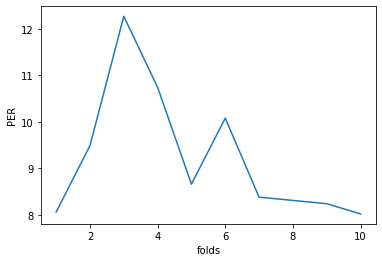

In [4]:
plt.plot(np.arange(1,11), test_pers)
plt.xlabel("folds")
plt.ylabel("PER")

In [5]:
print(np.mean(test_pers))

9.225


In [6]:
print(np.std(test_pers))

1.3423282012980282


In [7]:
test_pers

[8.06, 9.49, 12.27, 10.74, 8.66, 10.08, 8.38, 8.31, 8.24, 8.02]

In [8]:
np.mean(test_pers) + np.std(test_pers)

10.567328201298029